# Visualizing Neuronal Unit Spikes

Note: Some of this content is adapted from the [Allen SDK Documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_session.html).

After processing Neuropixel ecephys data with **[Kilosort](https://github.com/MouseLand/Kilosort)**, individual neuronal units have been identified and are stored in the units table, in the `Units` section of the NWB file. The units table contains information about hypothetical neurons determined by Kilosort. With this information and the stimulus information found in the stimulus tables of the `Intervals` section, this notebook helps examine the spiking behavior of these units in response to stimulus and their associated waveforms

### Environment Setup

In [1]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi_utils import dandi_download_open

%matplotlib inline

### Downloading Ecephys File
Change the values below to download the file you’re interested in. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, set `dandi_api_key` to your DANDI API key. If you want to stream a file instead of downloading it, use `dandi_stream_open` intead. Checkout [Streaming an NWB File with fsspec](../basics/stream_nwb.ipynb) for more details on this.

In [3]:
dandiset_id = "000021"
dandi_filepath = "sub-703279277/sub-703279277_ses-719161530.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
# This can sometimes take a while depending on the size of the file
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

File already exists
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.2.2 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Extracting Unit Data and Stimulus Data
Below, the `Units` table is read from the file. Individual units (putative neurons) are identified with the `id` column. Note that, while each id is unique, they are not perfectly ordinal; some ids are missing. In the cells below, the unit properties are listed and a slice of the units table is shown. More thorough descriptions of units and their properties can be found in [Visualizing Unit Quality Metrics](visualize_unit_metrics.ipynb)

Additionally, the stimulus data is also read from the NWB file's `Intervals` section. Stimulus information is stored as a series of tables depending on the type of stimulus shown in the session. One such table is displayed below.

In [5]:
units = nwb.units
units.colnames

('waveform_duration',
 'cluster_id',
 'peak_channel_id',
 'cumulative_drift',
 'amplitude_cutoff',
 'snr',
 'recovery_slope',
 'isolation_distance',
 'nn_miss_rate',
 'silhouette_score',
 'velocity_above',
 'quality',
 'PT_ratio',
 'l_ratio',
 'velocity_below',
 'max_drift',
 'isi_violations',
 'firing_rate',
 'amplitude',
 'local_index',
 'spread',
 'waveform_halfwidth',
 'd_prime',
 'presence_ratio',
 'repolarization_slope',
 'nn_hit_rate',
 'spike_times',
 'spike_amplitudes',
 'waveform_mean')

In [6]:
units[:10]

,waveform_duration,cluster_id,peak_channel_id,cumulative_drift,amplitude_cutoff,snr,recovery_slope,isolation_distance,nn_miss_rate,silhouette_score,...,local_index,spread,waveform_halfwidth,d_prime,presence_ratio,repolarization_slope,nn_hit_rate,spike_times,spike_amplitudes,waveform_mean
id,,,,,,,,,,,,,,,,,,,,,
950921187,0.604355,4,850249267,481.80,0.425574,2.209140,-0.118430,17.537571,0.009496,0.036369,...,4,50.0,0.357119,2.962274,0.99,0.381716,0.473829,"[1.0439430431793884, 1.543311060144649, 2.7287...","[0.0001908626967721937, 0.00016134635752077775...","[[0.0, 0.5961149999999966, 5.378099999999993, ..."
950921172,0.521943,3,850249267,681.53,0.390098,1.959983,-0.109729,14.677643,0.003857,0.103446,...,3,40.0,0.260972,2.067810,0.99,0.536663,0.445946,"[10.406435026164546, 17.127986534673788, 18.48...","[0.00014485615850768024, 0.0001722424107984555...","[[0.0, -1.341600000000002, -0.4586399999999933..."
950921152,0.467002,2,850249267,1070.71,0.500000,2.522905,-0.109867,15.783665,0.017776,0.027818,...,2,50.0,0.247236,2.220043,0.99,0.566559,0.284058,"[1.2775103414155262, 2.3915133536963493, 3.701...","[0.00014859435856024575, 0.0001531048673600236...","[[0.0, -0.6427199999999993, -2.836079999999998..."
950921135,0.467002,1,850249267,253.42,0.500000,2.803475,-0.150379,26.666930,0.023742,0.076530,...,1,40.0,0.233501,2.339206,0.99,0.669090,0.590737,"[9.473732504122962, 13.198542576065163, 18.302...","[0.00032386170367170055, 0.0004518112387675137...","[[0.0, -3.2800950000000078, -6.087510000000009..."
950921111,0.439531,0,850249267,141.82,0.018056,4.647943,-0.328727,66.901065,0.006595,NaN,...,0,30.0,0.219765,4.395994,0.99,1.261416,0.952667,"[1.1677100445138795, 1.1707767194728813, 1.349...","[0.00015644521007973124, 0.000214412247939483,...","[[0.0, -0.9291749999999945, -6.120270000000007..."
950927711,1.455946,482,850249273,2.46,0.000895,1.651500,-0.039932,39.400278,0.000033,NaN,...,464,100.0,0.274707,5.557479,0.37,0.467365,0.000000,"[2613.8652081509977, 2624.5193369599215, 2734....","[0.00012946663895843286, 0.0001203425053985725...","[[0.0, 6.3216435986159105, 10.324204152249129,..."
950921285,2.087772,11,850249273,318.53,0.036848,1.379817,NaN,27.472722,0.000903,0.291953,...,11,100.0,0.288442,2.751337,0.89,0.372116,0.258065,"[39.04904580954626, 39.457346913598556, 40.495...","[7.768399792002802e-05, 8.405736507197006e-05,...","[[0.0, 5.330324999999991, 2.4261899999999486, ..."
950921271,0.947739,10,850249273,1008.50,0.001727,1.420617,-0.008204,30.027595,0.000707,0.406673,...,10,100.0,0.288442,3.847234,0.96,0.498618,0.796491,"[16.751918851114475, 26.127977537450867, 28.65...","[0.00016516929470324686, 0.0001501058102103845...","[[0.0, -3.103230000000032, 5.680349999999983, ..."
950921260,0.453266,9,850249273,175.00,0.000081,4.969091,-0.184456,89.804006,0.000000,0.223876,...,9,60.0,0.192295,5.274090,0.99,1.140487,0.997333,"[0.9620761551434307, 2.092045877265143, 2.4040...","[0.0003836112198262231, 0.0004093908262843732,...","[[0.0, 1.9104149999999982, -7.270770000000016,..."


In [7]:
stimulus_names = nwb.intervals.keys()
print(stimulus_names)

dict_keys(['drifting_gratings_presentations', 'flashes_presentations', 'gabors_presentations', 'invalid_times', 'natural_movie_one_presentations', 'natural_movie_three_presentations', 'natural_scenes_presentations', 'spontaneous_presentations', 'static_gratings_presentations'])


In [8]:
stim_table = nwb.intervals["flashes_presentations"]
stim_table[:]

,start_time,stop_time,stimulus_name,stimulus_block,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,
0,1290.883097,1291.133309,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3647, 1, timestamps pynwb.base.TimeSeries at..."
1,1292.884817,1293.135016,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3648, 1, timestamps pynwb.base.TimeSeries at..."
2,1294.886487,1295.136691,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3649, 1, timestamps pynwb.base.TimeSeries at..."
3,1296.888137,1297.138344,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3650, 1, timestamps pynwb.base.TimeSeries at..."
4,1298.889787,1299.140004,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3651, 1, timestamps pynwb.base.TimeSeries at..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1581.125517,1581.375726,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3792, 1, timestamps pynwb.base.TimeSeries at..."
146,1583.127217,1583.377419,flashes,1.0,1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3793, 1, timestamps pynwb.base.TimeSeries at..."
147,1585.128807,1585.379029,flashes,1.0,-1.0,None,1.0,"[0.0, 0.0]","[300.0, 300.0]",deg,1.0,0.0,"[0.0, 0.0]",0.8,[stimulus_time_interval],"[(3794, 1, timestamps pynwb.base.TimeSeries at..."


### Getting Stimulus Epochs
Here, *epochs* are extracted from the stimulus tables. In this case, an epoch is a continuous period of time during a session where a particular type of stimulus is shown. The output here is a list of epochs, where an epoch is a tuple of four values; the stimulus name, the stimulus block, the starting time and the ending time. Since stimulus information can vary signifcantly between experiments and NWB files, you may need to tailor the code below to extract epochs for the file you're interested in. 

In [9]:
# extract epoch times from stim table where stimulus rows have a different 'block' than following row
# returns list of epochs, where an epoch is of the form (stimulus name, stimulus block, start time, stop time)
def extract_epochs(stim_name, stim_table, epochs):
    
    # specify a current epoch stop and start time
    epoch_start = stim_table.start_time[0]
    epoch_stop = stim_table.stop_time[0]

    # for each row, try to extend current epoch stop_time
    for i in range(len(stim_table)):
        this_block = stim_table.stimulus_block[i]
        # if end of table, end the current epoch
        if i+1 >= len(stim_table):
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            break
            
        next_block = stim_table.stimulus_block[i+1]
        # if next row is the same stim block, push back epoch_stop time
        if next_block == this_block:
            epoch_stop = stim_table.stop_time[i+1]
        # otherwise, end the current epoch, start new epoch
        else:
            epochs.append((stim_name, this_block, epoch_start, epoch_stop))
            epoch_start = stim_table.start_time[i+1]
            epoch_stop = stim_table.stop_time[i+1]
    
    return epochs

In [10]:
# extract epochs from all valid stimulus tables
epochs = []
for stim_name in stimulus_names:
    stim_table = nwb.intervals[stim_name]
    try:
        epochs = extract_epochs(stim_name, stim_table, epochs)
    except:
        continue

# epochs take the form (stimulus name, stimulus block, start time, stop time)
print(len(epochs))
epochs.sort(key=lambda x: x[2])
for epoch in epochs:
    print(epoch)

15
('gabors_presentations', 0.0, 89.8968273815905, 1001.8917716749913)
('flashes_presentations', 1.0, 1290.8830973815907, 1589.382401312724)
('drifting_gratings_presentations', 2.0, 1591.1338573815906, 2190.634543106125)
('natural_movie_three_presentations', 3.0, 2221.6604473815905, 2822.161967381591)
('natural_movie_one_presentations', 4.0, 2852.1870373815905, 3152.4377773815904)
('drifting_gratings_presentations', 5.0, 3182.4628573815908, 3781.963503106125)
('natural_movie_three_presentations', 6.0, 4083.215117381591, 4683.716567381592)
('drifting_gratings_presentations', 7.0, 4713.741627381592, 5397.312443106124)
('static_gratings_presentations', 8.0, 5398.31325738159, 5878.714467381591)
('natural_scenes_presentations', 9.0, 5908.739537381591, 6389.157337381589)
('natural_scenes_presentations', 10.0, 6689.408117381589, 7169.809297381591)
('static_gratings_presentations', 11.0, 7199.83431738159, 7680.268867381591)
('natural_movie_one_presentations', 12.0, 7710.293937381591, 8010.5446

### Visualizing Unit Activity Throughout Epochs
Below is a view of the spiking activity of a unit throughout a session, where epochs are shown as colored sections. Set `unit_num` to be the id of the unit to view. Set `time_start` to the starting bound in seconds of the session, you'd like to see, and `time_end` to the ending bound. You may want to use the output above to inform your choice. As mentioned above, if your file's stimulus information differs signifcantly, this code may need to be modified to appropriately display the epochs.

In [11]:
unit_num = 950930672 # chosen from units table
time_start = 0
time_end = 10000

In [12]:
# translate unit id to row index
unit_idx = -1
for i in range(len(units.id)):
    if units.id[i] == unit_num:
        unit_idx = i
        break
print("Unit index:",unit_idx)

Unit index: 648


In [13]:
# make histogram of unit spikes per second over specified timeframe
spikes = units["spike_times"][unit_idx]
time_bin_edges = np.linspace(time_start, time_end, (time_end-time_start))
hist, bins = np.histogram(spikes, bins=time_bin_edges)

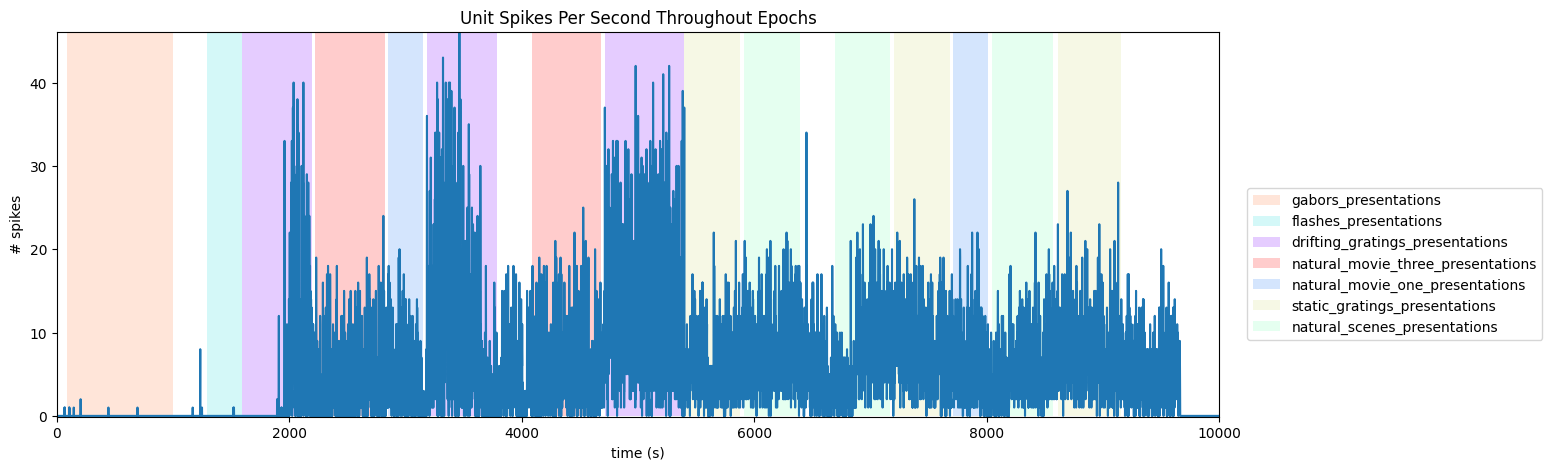

In [14]:
# generate plot of spike histogram with colored epoch intervals and legend
fig, ax = plt.subplots(figsize=(15,5))

# assign unique color to each stimulus name
stim_names = list({epoch[0] for epoch in epochs})
colors = plt.cm.rainbow(np.linspace(0,1,len(stim_names)))
stim_color_map = {stim_names[i]:colors[i] for i in range(len(stim_names))}

epoch_key = {}
height = max(hist)
# draw colored rectangles for each epoch
for epoch in epochs:
    stim_name, stim_block, epoch_start, epoch_end = epoch
    color = stim_color_map[stim_name]
    rec = ax.add_patch(mpl.patches.Rectangle((epoch_start, 0), epoch_end-epoch_start, height, alpha=0.2, facecolor=color))
    epoch_key[stim_name] = rec
    
ax.set_xlim(time_start, time_end)
ax.set_ylim(-0.1, height+0.1)
ax.set_xlabel("time (s)")
ax.set_ylabel("# spikes")
ax.set_title("Unit Spikes Per Second Throughout Epochs")

fig.legend(epoch_key.values(), epoch_key.keys(), loc="lower right", bbox_to_anchor=(1.12, 0.25))
ax.plot(bins[:-1], hist)

### Probewise Activity Throughout Epochs
It can also be useful to view the activity of an entire probe throughout epochs. The code below allows users to select a probe and a histogram is produced for the total of all unit spiking counts over time for one probe. To do this, the file's `Electrodes` table is used. To understand this, you need not know anything about the `Electrodes` table, except that it can be used to map channel IDs to probe IDs. Below is printed a list of the probe names to choose from. Set `probe_name` to one of these. Set `time_start` and `time_end` to the start and ending times, in seconds, to view in the session.

In [15]:
print(nwb.devices.keys())

dict_keys(['probeA', 'probeB', 'probeC', 'probeD', 'probeE', 'probeF'])


In [16]:
probe_name = "probeC"
time_start = 0
time_end = 10000

In [17]:
# get list of channels on this probe
electrodes = nwb.electrodes.to_dataframe()
channel_ids = set(electrodes.index[electrodes["group_name"] == probe_name].tolist())

# get all spike times from units whose peak channel belongs to the selected probe
probe_spike_times = []
for i in range(len(units)):
    if units["peak_channel_id"][i] in channel_ids:
        probe_spike_times += list(units["spike_times"][i])
    
len(probe_spike_times)

27741944

In [18]:
# make histogram of unit spikes per second over specified timeframe
time_bin_edges = np.linspace(time_start, time_end, (time_end-time_start))
hist, bins = np.histogram(probe_spike_times, bins=time_bin_edges)

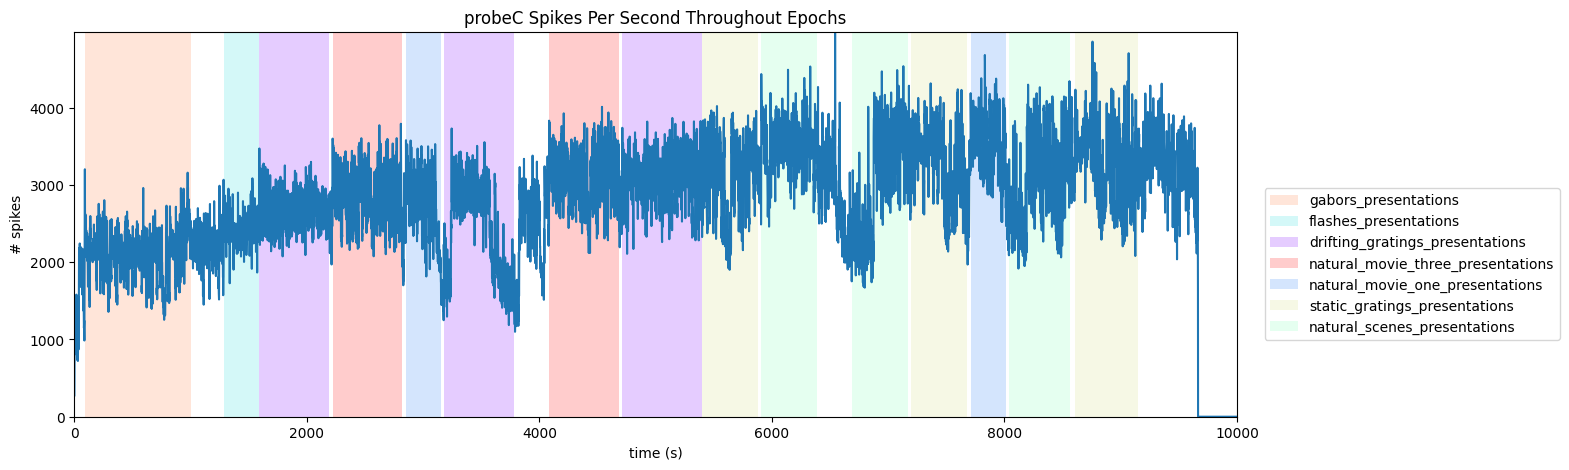

In [19]:
# generate plot of spike histogram with colored epoch intervals and legend
fig, ax = plt.subplots(figsize=(15,5))

# assign unique color to each stimulus name
stim_names = list({epoch[0] for epoch in epochs})
colors = plt.cm.rainbow(np.linspace(0,1,len(stim_names)))
stim_color_map = {stim_names[i]:colors[i] for i in range(len(stim_names))}

epoch_key = {}
height = max(hist)
# draw colored rectangles for each epoch
for epoch in epochs:
    stim_name, stim_block, epoch_start, epoch_end = epoch
    color = stim_color_map[stim_name]
    rec = ax.add_patch(mpl.patches.Rectangle((epoch_start, 0), epoch_end-epoch_start, height, alpha=0.2, facecolor=color))
    epoch_key[stim_name] = rec
    
ax.set_xlim(time_start, time_end)
ax.set_ylim(-0.1, height+0.1)
ax.set_xlabel("time (s)")
ax.set_ylabel("# spikes")
ax.set_title(f"{probe_name} Spikes Per Second Throughout Epochs")

fig.legend(epoch_key.values(), epoch_key.keys(), loc="lower right", bbox_to_anchor=(1.12, 0.25))
ax.plot(bins[:-1], hist)

### Regionwise Activity Throughout Epochs
We can also break down our activity based on brain regions (with a bit of work). To do this, we must first be able to retrieve the brain region of each unit. The trick to do this lay in the `Electrodes` table, shown below. The `Electrodes` table contains the brain region for each electrode id, while the `Units` table (shown above) contains the `Peak Channel ID` for each Unit. These can be used together to get the brain region of each unit's peak channel. Once this is done, this information can be used just like the Probe selection above to get to get spike counts over time of each Unit in a selected region. Below, set `brain_region`, `start_time`, and `end_time` to view such a plot.

In [20]:
nwb.electrodes[:10]

,x,y,z,imp,location,filtering,group,group_name,probe_vertical_position,probe_horizontal_position,probe_id,local_index,valid_data
id,,,,,,,,,,,,,
850249265,7955.0,3766.0,3766.0,NaN,Eth,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x26648932...,probeB,20,43,729445650,0,False
850249267,7955.0,3756.0,3756.0,NaN,TH,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x26648932...,probeB,20,11,729445650,1,True
850249273,7955.0,3727.0,3727.0,NaN,TH,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x26648932...,probeB,60,43,729445650,4,True
850249277,7954.0,3708.0,3708.0,NaN,APN,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x26648932...,probeB,80,59,729445650,6,True
850249283,7954.0,3679.0,3679.0,NaN,APN,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x26648932...,probeB,100,11,729445650,9,True
850249289,7953.0,3640.0,3640.0,NaN,APN,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x26648932...,probeB,140,43,729445650,12,True
850249295,7952.0,3612.0,3612.0,NaN,APN,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x26648932...,probeB,160,27,729445650,15,True
850249299,7952.0,3593.0,3593.0,NaN,APN,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x26648932...,probeB,180,11,729445650,17,True
850249305,7951.0,3565.0,3565.0,NaN,APN,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,probeB abc.EcephysElectrodeGroup at 0x26648932...,probeB,220,43,729445650,20,True


In [21]:
# map electrode ids to brain region acronyms
electrode_locations = {nwb.electrodes["id"][i]: nwb.electrodes["location"][i] for i in range(len(nwb.electrodes))}
print(set(electrode_locations.values()))

{'', 'CA2', 'grey', 'LP', 'VISrl', 'CA3', 'APN', 'VISal', 'VISp', 'CA1', 'VISpm', 'Eth', 'MB', 'VPM', 'PO', 'SUB', 'LGd', 'DG', 'NOT', 'POL', 'TH', 'VISam', 'VL', 'VISl'}


In [22]:
brain_region = "VISpm"
time_start = 0
time_end = 10000

In [23]:
# get all spike times from units whose peak channel belongs to the selected brain region
region_spike_times = []
for i in range(len(units)):
    unit_channel = units["peak_channel_id"][i]
    unit_location = electrode_locations.get(unit_channel, None)
    if unit_location == brain_region:
        region_spike_times += list(units["spike_times"][i])
    
len(region_spike_times)

4178172

In [24]:
# make histogram of unit spikes per second over specified timeframe
time_bin_edges = np.linspace(time_start, time_end, (time_end-time_start))
hist, bins = np.histogram(region_spike_times, bins=time_bin_edges)

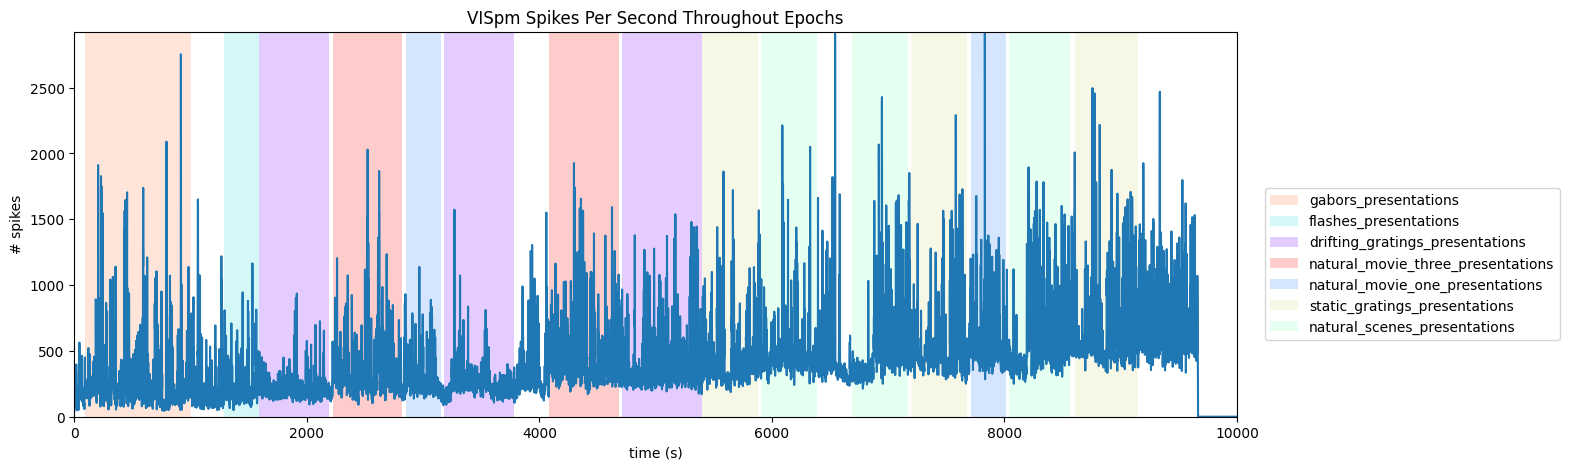

In [25]:
# generate plot of spike histogram with colored epoch intervals and legend
fig, ax = plt.subplots(figsize=(15,5))

# assign unique color to each stimulus name
stim_names = list({epoch[0] for epoch in epochs})
colors = plt.cm.rainbow(np.linspace(0,1,len(stim_names)))
stim_color_map = {stim_names[i]:colors[i] for i in range(len(stim_names))}

epoch_key = {}
height = max(hist)
# draw colored rectangles for each epoch
for epoch in epochs:
    stim_name, stim_block, epoch_start, epoch_end = epoch
    color = stim_color_map[stim_name]
    rec = ax.add_patch(mpl.patches.Rectangle((epoch_start, 0), epoch_end-epoch_start, height, alpha=0.2, facecolor=color))
    epoch_key[stim_name] = rec
    
ax.set_xlim(time_start, time_end)
ax.set_ylim(-0.1, height+0.1)
ax.set_xlabel("time (s)")
ax.set_ylabel("# spikes")
ax.set_title(f"{brain_region} Spikes Per Second Throughout Epochs")

fig.legend(epoch_key.values(), epoch_key.keys(), loc="lower right", bbox_to_anchor=(1.12, 0.25))
ax.plot(bins[:-1], hist)

### Showing Spike Times
Here, a histogram plot of unit spikes over time is created. In the second cell below, set `stim_time` to be the time of the stimulus you're interested in viewing. To get an idea of the stimulus times you might be interested in, access one of the tables in the `Intervals` section, discussed above in **Extracting Unit Data and Stimulus Data**.  The first cell below shows how to access these. Set `interval_start` and `interval_end` to the relative time bounds, in seconds, of the histogram around `stim_time`. Finally, `start_unit` and `end_unit` can be used to choose the slice indices of `selected_units` to display. 

In [26]:
stim_time = 1007 # arbitrarily chosen here
interval_start = -0.1
interval_end = 5

start_unit = 100
end_unit = 500

In [27]:
spike_times = [elem for elem in units["spike_times"][start_unit:end_unit]]
if len(spike_times) == 0:
    raise Exception("There are no spiking units in this selection")
len(spike_times)

400

In [28]:
# for each unit, generate a histogram with 200 bins, where bins represent the number spikes per second
time_bin_edges = np.linspace(interval_start, interval_end, 200)
hists = []
for unit_spike_times in spike_times:
    hist, bins = np.histogram(unit_spike_times-stim_time, bins=time_bin_edges)
    hists.append(hist)
hists = np.array(hists)

hists.shape

(400, 199)

Text(0.5, 1.0, 'Units Spikes Over Time')

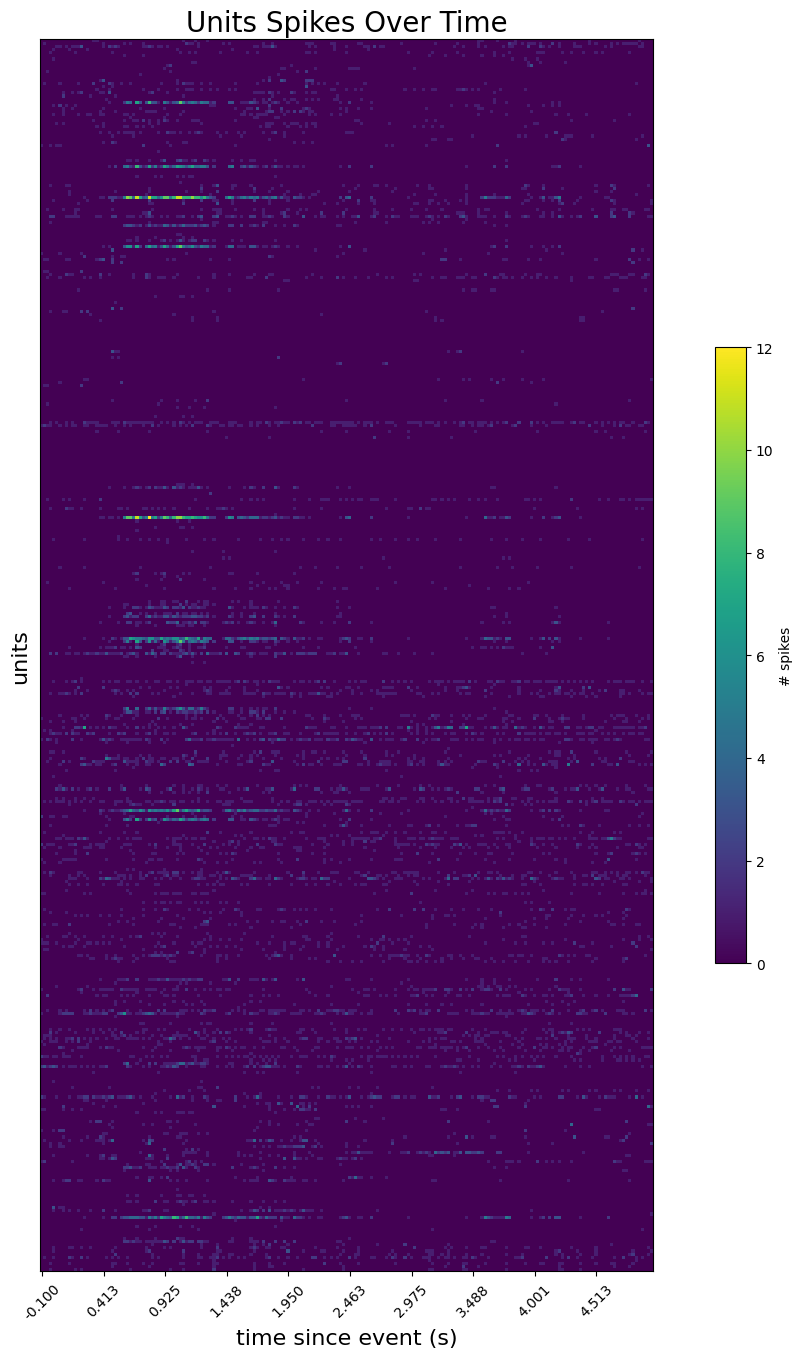

In [29]:
# display array of histograms as 2D image with color
fig, ax = plt.subplots(figsize=(16,16))
img = ax.imshow(hists)
cbar = plt.colorbar(img, shrink=0.5)
cbar.set_label('# spikes')

ax.yaxis.set_major_locator(plt.NullLocator())
ax.set_ylabel("units", fontsize=16)

xtick_step=20
reltime = np.array(time_bin_edges)
ax.set_xticks(np.arange(0, len(reltime), xtick_step))
ax.set_xticklabels([f'{mp:1.3f}' for mp in reltime[::xtick_step]], rotation=45)

ax.set_xlabel("time since event (s)", fontsize=16)
ax.set_title("Units Spikes Over Time", fontsize=20)

### Visualizing Waveforms
The `Units` table can also be used to view the waveforms of a units with the `waveform_mean` property, which consists of the mean waveform of that unit as measured by each channel along the probe. One channel will contain the peak waveform. With a bit of legwork, the `peak_channel_id` of the unit and the `Electrodes` table can be used to get the single peak waveform as shown below. Just as in the sections above, you don't need to fully understand the `Electrodes` table except that it can be used to map channel IDs to probe IDs. There is also a timewise and channelwise view of all the mean waveforms and an average of the waveforms across all channels. 

In [30]:
unit_num = 950952910

In [31]:
# translate unit id to row index
unit_idx = -1
for i in range(len(units.id)):
    if units.id[i] == unit_num:
        unit_idx = i
        break
print("Unit index:",unit_idx)

Unit index: 2513


In [32]:
# get sampling Hz for this unit's waveform
peak_channel_id = units["peak_channel_id"][unit_idx]
electrodes = nwb.electrodes.to_dataframe()
probe_name = electrodes.loc[peak_channel_id].group_name

Hz = nwb.devices[probe_name].sampling_rate
Hz

29999.9995000281

#### Peak waveform

In [33]:
# use peak_channel_id of unit to fetch the peak waveform index from electrodes table
peak_channel_id = units["peak_channel_id"][unit_idx]
electrodes = nwb.electrodes.to_dataframe()
local_index = electrodes.loc[peak_channel_id].local_index

unit_waveform = units["waveform_mean"][unit_idx]
peak_waveform = unit_waveform[local_index]

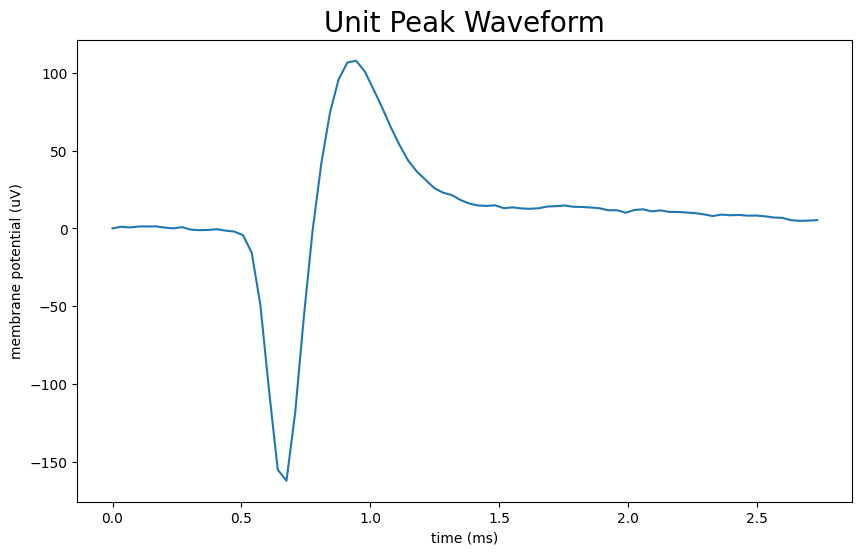

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

n_secs = peak_waveform.shape[0] / Hz
time_axis = np.linspace(0, n_secs * 1000, peak_waveform.shape[0])

ax.plot(time_axis, peak_waveform)

ax.set_xlabel("time (ms)")
ax.set_ylabel("membrane potential (uV)")
ax.set_title("Unit Peak Waveform", fontsize=20)

plt.show()

#### Waveforms

In [35]:
unit_waveforms = units["waveform_mean"][unit_idx]
unit_waveforms.shape

(384, 82)

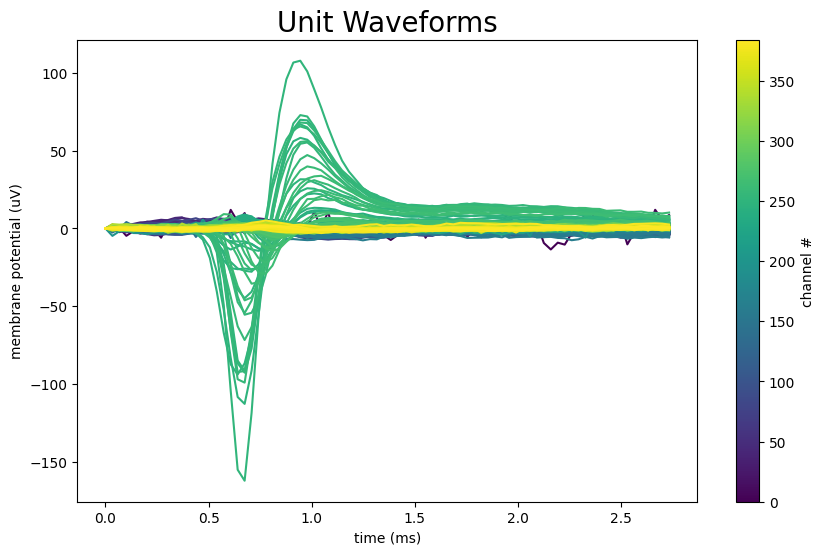

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
colors = plt.cm.viridis(np.linspace(0, 1, unit_waveforms.shape[0]))
ax.set_prop_cycle(color=colors)

n_secs = unit_waveforms.shape[1] / Hz
time_axis = np.linspace(0, n_secs * 1000, unit_waveforms.shape[1])

ax.plot(time_axis, np.transpose(unit_waveforms))

norm = mpl.colors.Normalize(vmin=0, vmax=len(colors))
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=ax, label='channel #')

ax.set_xlabel("time (ms)")
ax.set_ylabel("membrane potential (uV)")
ax.set_title("Unit Waveforms", fontsize=20)

plt.show()

#### Waveform Image
Below is an image of the waveform means for each channel of a unit. The further in space from the real neuron, the weaker the measurment of the response waveform, so it is usualyl only useful to view a subsection of the channels at once. Set `start_channel` and `end_channel` to be the bounds of the channels you want displayed. Because the channels are arranged into two rows along the length of a probe, typically a unit is only strongly detected by every other channel. The data shown below displays every other channel to avoid the resultant striping effect. If the waveform looks too dim, try incrementing `start_channel` by 1.

In [37]:
start_channel = 230
end_channel = 280

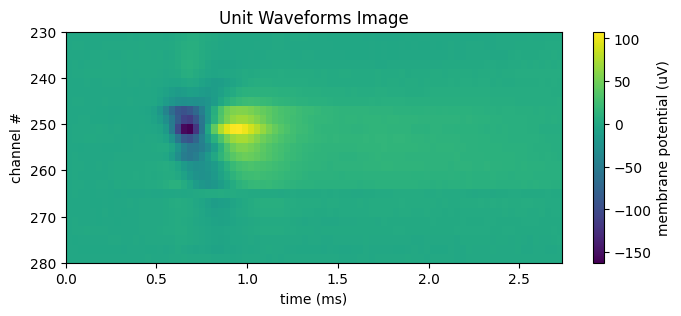

In [38]:
data = unit_waveforms[start_channel:end_channel:2] # step by 2 to remove striping effect
n_channels = end_channel - start_channel

fig, ax = plt.subplots(figsize=(8, n_channels // 15))

n_secs = unit_waveforms.shape[1] / Hz
time_axis = np.linspace(0, n_secs * 1000, unit_waveforms.shape[1])

norm = mpl.colors.Normalize(vmin=np.min(data), vmax=np.max(data))
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=ax, label="membrane potential (uV)")

ax.set_xlabel("time (ms)")
ax.set_ylabel("channel #")
ax.set_title("Unit Waveforms Image")

ax.imshow(data, vmin=np.min(data), vmax=np.max(data), extent=[0, n_secs*1000, end_channel, start_channel], aspect="auto")

#### Average waveform across channels

In [39]:
avg_waveform = np.average(units["waveform_mean"][unit_idx], axis=0)
avg_waveform.shape

(82,)

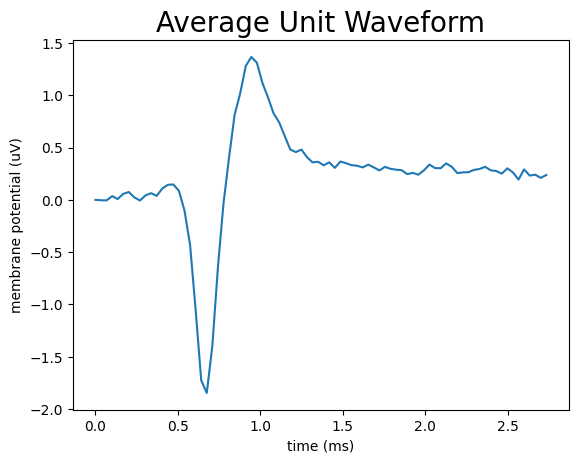

In [40]:
fig, ax = plt.subplots()

n_secs = avg_waveform.shape[0] / Hz
time_axis = np.linspace(0, n_secs * 1000, unit_waveforms.shape[1])

ax.plot(time_axis, avg_waveform)

ax.set_xlabel("time (ms)")
ax.set_ylabel("membrane potential (uV)")
ax.set_title("Average Unit Waveform", fontsize=20)

plt.show()